# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

## Import the Libraries

In [ ]:
import numpy as np
import os
import datetime
import os
import random as rn
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

from imageio import imread
from skimage.transform import resize

from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Bidirectional, Flatten,RepeatVector, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications.vgg16 import VGG16

tf.__version__

'2.9.2'

## Import the Dataset

Mount your Google Drive and unzip the dataset into the workspace.
The dataset must be in following folder on your Google Drive:
```
Gesture_Recognition_Project/Project_data.zip
```

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/Gesture_Recognition_Project/Project_data.zip
drive.flush_and_unmount()

Streaming output truncated to the last 5000 lines.
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00001.png  
 extracting: Project_data/t

Set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
rn.seed(30)
tf.keras.utils.set_random_seed(30)

Set the folder names for training and validation.

In [ ]:
train_doc = np.random.permutation(open('/content/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/Project_data/val.csv').readlines())

## Generator
Using all the imgages in the sequences gives the best results.  But one can skip over every second image in the sequence to reduce the memory footprint by setting:

```
img_idx = [*range(1, 30, 2)]
```

The image dimensions used are 120x120 pixels.  Images that are 160x120 are cropped to 120x120, and images that are 360x360 are resized using a Lanczos filter.  Resizing images by an integer factor minimizes the introduction of resizing artifacts.



In [ ]:
# Define the image indexes to use
# Using all the imgages in the sequence gives the best results
img_idx = list(range(0,30))

# But you can skip over every second image to reduce memory usage 
# img_idx = [*range(1, 30, 2)]

# Define the image frame size
image_width = 120
image_height = 120

# Define the function with load data from
def generator(source_path, folder_list, batch_size, scale_zero_centered):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    x=len(img_idx)

    # (y,z) is the final size of the input images
    # use 120x120 pixels for exact division so resizing will not introduce artifacts, original images are 360x360 and 120x160
    y=image_width
    z=image_height
    
    while True:
        shuf = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size
        path_inter = 0
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,x,y,z,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ shuf[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ shuf[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    # Crop the image if the size is 120x160
                    if image.shape[0] == 120 and image.shape[1] == 160:
                        image = image[0:120, 20:140]
                    else:
                        # Resize the image
                        image = cv2.resize(image, (y,z), interpolation=cv2.INTER_LANCZOS4)
                    
                    # Normalise and feed in the image
                    if scale_zero_centered == True:
                        batch_data[folder,idx,:,:,0] = (image[:,:,0] - 127) / 127.
                        batch_data[folder,idx,:,:,1] = (image[:,:,1] - 127) / 127.
                        batch_data[folder,idx,:,:,2] = (image[:,:,2] - 127) / 127.
                    else:
                        batch_data[folder,idx,:,:,0] = image[:,:,0] / 255.
                        batch_data[folder,idx,:,:,1] = image[:,:,1] / 255.
                        batch_data[folder,idx,:,:,2] = image[:,:,2] / 255.
                    
                batch_labels[folder, int(shuf[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            path_inter = batch
            yield batch_data, batch_labels        
        
        folders_not_process = len(folder_list)-num_batches*batch_size # vidu bang 3
        if folders_not_process !=0:
            path_inter+=1
            batch_data = np.zeros((folders_not_process,x,y,z,3))
            batch_labels = np.zeros((folders_not_process,5))

            for folder in range(folders_not_process):
                imgs = os.listdir(source_path+'/'+ shuf[folder + (path_inter*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ shuf[folder + (path_inter*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    # Crop the image if the size is 120x160
                    if image.shape[0] == 120 and image.shape[1] == 160:
                        image = image[0:120, 20:140]
                    else:
                        # Resize the image
                        image = cv2.resize(image, (y,z), interpolation=cv2.INTER_LANCZOS4)
                    
                    # Normalise and feed in the image
                    if scale_zero_centered == True:
                        batch_data[folder,idx,:,:,0] = (image[:,:,0] - 127) / 127.
                        batch_data[folder,idx,:,:,1] = (image[:,:,1] - 127) / 127.
                        batch_data[folder,idx,:,:,2] = (image[:,:,2] - 127) / 127.
                    else:
                        batch_data[folder,idx,:,:,0] = image[:,:,0] / 255.
                        batch_data[folder,idx,:,:,1] = image[:,:,1] / 255.
                        batch_data[folder,idx,:,:,2] = image[:,:,2] / 255.
                    
                batch_labels[folder, int(shuf[folder + (path_inter*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [ ]:
# Capture the current time
curr_dt_time = datetime.datetime.now()

# Define the data paths
train_path = '/content/Project_data/train'
val_path = '/content/Project_data/val'
num_train_sequences = len(train_doc)
print('Training sequences:', num_train_sequences)
num_val_sequences = len(val_doc)
print('Validation sequences:', num_val_sequences)

Training sequences: 663
Validation sequences: 100


## Model Definitions


In [ ]:
class Gesture_Module:
    def __init__(self, input_shape, no_class):
        self.input_shape = input_shape
        self.no_class = no_class
        
    def cnn3d_lstm(self):
        model = Sequential(name='cnn3D_lstm')

        model.add(Conv3D(32, (3,3,3), input_shape=self.input_shape))
        model.add(MaxPooling3D((2,2,2)))
        model.add(Dropout(0.2))
        
        model.add(Conv3D(64, (3,3,3), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D((2,2,2)))
        model.add(Dropout(0.2))
        
        model.add(Conv3D(64, (3,3,3), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D((2,2,2)))
        model.add(Dropout(0.2))
        model.add(Flatten())

        model.add(RepeatVector(len(img_idx)))
        model.add(LSTM(64, return_sequences=False, dropout=0.25, recurrent_dropout=0.25))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.no_class, activation='softmax'))
        return model

    def cnn_lstm(self):
        model = Sequential(name='cnn_lstm')
        model.add(TimeDistributed(Conv2D(8,(3,3),strides=(2,2)), input_shape=self.input_shape))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Activation('relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

        model.add(TimeDistributed(Conv2D(32,(3,3))))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Activation('relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

        model.add(TimeDistributed(Conv2D(64,(3,3))))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Activation('relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

        model.add(TimeDistributed(Conv2D(128,(3,3))))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Activation('relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

        model.add(TimeDistributed(Flatten()))

        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(64, activation='relu'))
        model.add(LSTM(64, return_sequences=False))
        model.add(Dense(self.no_class, activation='softmax'))
        return model

    def cnn_gru(self):
        model = Sequential(name='cnn_gru')
        model.add(TimeDistributed(Conv2D(8,(3,3),strides=(2,2)), input_shape=self.input_shape))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Activation('relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

        model.add(TimeDistributed(Conv2D(32,(3,3))))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Activation('relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

        model.add(TimeDistributed(Conv2D(64,(3,3))))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Activation('relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

        model.add(TimeDistributed(Conv2D(128,(3,3))))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(Activation('relu')))
        model.add(TimeDistributed(MaxPooling2D((2,2), strides=(2,2))))

        model.add(TimeDistributed(Flatten()))

        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(64, activation='relu'))
        model.add(GRU(64, return_sequences=False))
        model.add(Dense(self.no_class, activation='softmax'))
        return model

    def pretrained_vgg_lstm(self):
        vgg_structure = VGG16(include_top=False,
                              weights='imagenet',
                              input_shape=(120, 120, 3))
        
        vgg_output = vgg_structure.layers[-1].output
        vgg_output = Flatten()(vgg_output)
        vgg_backbone = Model(vgg_structure.input, outputs=vgg_output)
        
        for layer in vgg_backbone.layers:
            layer.trainable = False
        
        pretrained_vgg_lstm = Sequential(name='pretrained_vgg16_lstm')
        pretrained_vgg_lstm.add(TimeDistributed(vgg_backbone, input_shape=self.input_shape))
        pretrained_vgg_lstm.add(TimeDistributed(Flatten()))
        pretrained_vgg_lstm.add(LSTM(128, activation='relu', return_sequences=False))
        pretrained_vgg_lstm.add(Dense(32, activation='relu'))
        pretrained_vgg_lstm.add(Dropout(0.25))
        pretrained_vgg_lstm.add(Dense(self.no_class, activation='softmax'))
        return pretrained_vgg_lstm

    def pretrained_vgg_gru(self):
        vgg_structure = VGG16(include_top=False,
                              weights='imagenet',
                              input_shape=(self.input_shape[1:]))
        
        vgg_output = vgg_structure.layers[-1].output
        vgg_output = Flatten()(vgg_output)
        vgg_backbone = Model(vgg_structure.input, outputs=vgg_output)
        
        for layer in vgg_backbone.layers:
            layer.trainable = False
        
        pretrained_vgg_gru = Sequential(name='pretrained_vgg16_gru')
        pretrained_vgg_gru.add(TimeDistributed(vgg_backbone, input_shape=self.input_shape))
        pretrained_vgg_gru.add(TimeDistributed(Flatten()))
        pretrained_vgg_gru.add(GRU(256, activation='relu', return_sequences=False))
        pretrained_vgg_gru.add(BatchNormalization())
        pretrained_vgg_gru.add(Dropout(0.25))
        pretrained_vgg_gru.add(Dense(32, activation='relu'))
        pretrained_vgg_gru.add(BatchNormalization())
        pretrained_vgg_gru.add(Dropout(0.25))
        pretrained_vgg_gru.add(Dense(self.no_class, activation='softmax'))
        return pretrained_vgg_gru

Configure and instantiate the model class

In [ ]:
# Number of classification classes
no_class = 5

# Input shape
input_shape = (len(img_idx), image_height, image_width, 3)

# Instantiate the model class
GestureNet = Gesture_Module(input_shape, no_class)

## Plotting Functions

In [ ]:
# Function to plot the model accuracy
def plot_accuracy(history):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Function to plot the model loss
def plot_loss(history):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## Pretrained VGG16 + GRU Model

In [ ]:
# Set the batch size
batch_size = 6

# Configurate the generator
train_generator = generator(train_path, train_doc, batch_size, scale_zero_centered=True)
val_generator = generator(val_path, val_doc, batch_size, scale_zero_centered=True)

# Calculate the number of steps
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# Prepare for training
input_shape = (len(img_idx), image_height, image_width, 3)

pretrained_vgg_gru = GestureNet.pretrained_vgg_gru()

model_name = pretrained_vgg_gru.name + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
    
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.2,
                                         patience=5,
                                         mode='auto',
                                         min_lr=1e-5)
callbacks_list = [checkpoint, LR]

opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
pretrained_vgg_gru.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(pretrained_vgg_gru.summary())

Model: "pretrained_vgg16_gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  (None, 30, 4608)         14714688  
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 4608)         0         
 tributed)                                                       
                                                                 
 gru_1 (GRU)                 (None, 256)               3737088   
                                                                 
 batch_normalization_8 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 32)                8224      
                                              

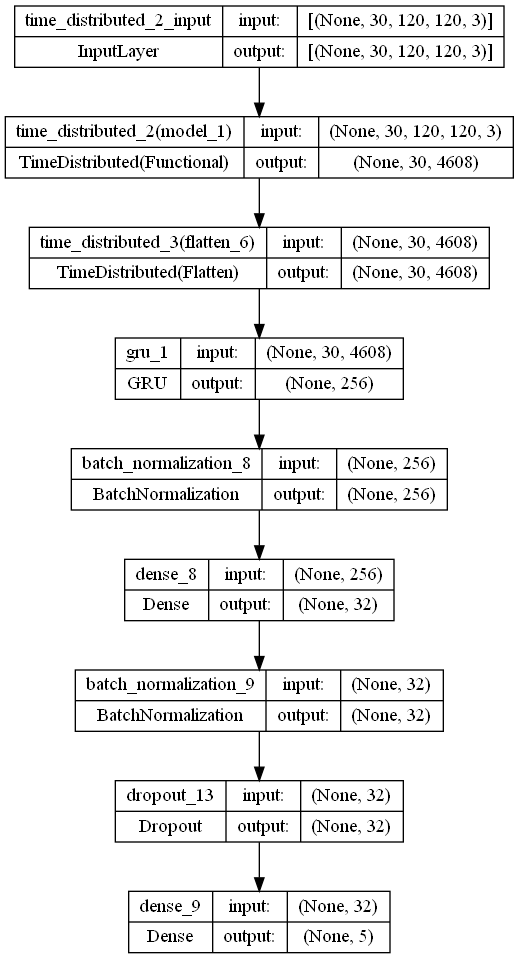

In [ ]:
# Plot a diagram of the model
tf.keras.utils.plot_model(pretrained_vgg_gru, "vgg_gru.png", show_shapes=True)

In [ ]:
# Train the model for 50 epochs
pretrained_vgg_gru.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1, 
                                 callbacks=callbacks_list, validation_data=val_generator, 
                                 validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\Gert\AppData\Local\Temp/ipykernel_47952/1365569545.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  pretrained_vgg_gru.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1,


Source path =  C:/development/data/Project_data/train ; batch size = 6
Epoch 1/50
111/111 [==============================] - ETA: 0s - loss: 1.1859 - categorical_accuracy: 0.5671Source path =  C:/development/data/Project_data/val ; batch size = 6

Epoch 1: saving model to pretrained_vgg16_gru_2022-11-1315_52_15.807866\model-00001-1.18592-0.56712-0.97414-0.68000.h5
111/111 [==============================] - 76s 655ms/step - loss: 1.1859 - categorical_accuracy: 0.5671 - val_loss: 0.9741 - val_categorical_accuracy: 0.6800 - lr: 0.0010
Epoch 2/50
111/111 [==============================] - ETA: 0s - loss: 0.6056 - categorical_accuracy: 0.7919
Epoch 2: saving model to pretrained_vgg16_gru_2022-11-1315_52_15.807866\model-00002-0.60555-0.79186-0.53494-0.78000.h5
111/111 [==============================] - 76s 684ms/step - loss: 0.6056 - categorical_accuracy: 0.7919 - val_loss: 0.5349 - val_categorical_accuracy: 0.7800 - lr: 0.0010
Epoch 3/50
111/111 [==============================] - ETA: 0s - 

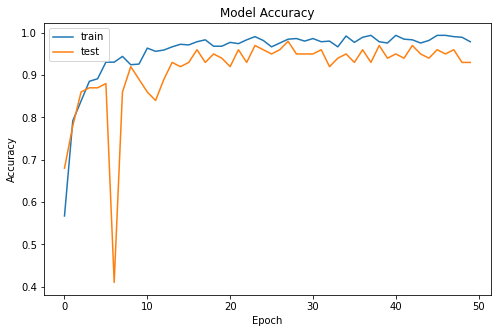

In [ ]:
# Plot the model accuracy
plot_accuracy(pretrained_vgg_gru.history)

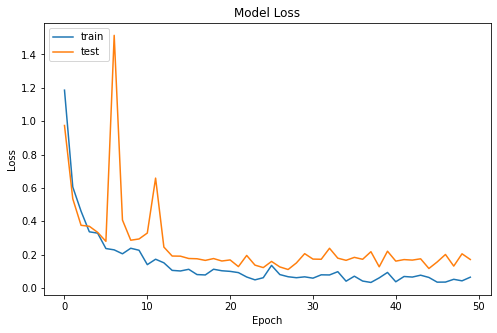

In [ ]:
# Plot the model loss
plot_loss(pretrained_vgg_gru.history)